In [1]:
from torchvision import datasets, models, transforms
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import os
import matplotlib.pyplot as plt
import torchvision
import numpy as np
import tensorflow as tf
import random
from torchsummary import summary
import shap

In [2]:
batch_size = 4
data_transforms = {
    'Training': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'Testing': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

#Assigning the data directory
data_dir = 'mri'


#Assinging the training and testing folder of the data with os path-joiner
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['Training', 'Testing']}



#defining the image batch size, initiate image data shuffling and num_workers
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size,
                                             shuffle=True, num_workers=4)
              for x in ['Training', 'Testing']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['Training', 'Testing']}

#finding class names from the training data folder
class_names = image_datasets['Training'].classes


#Initiating condition for device selection whether it will be using GPU or CPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")



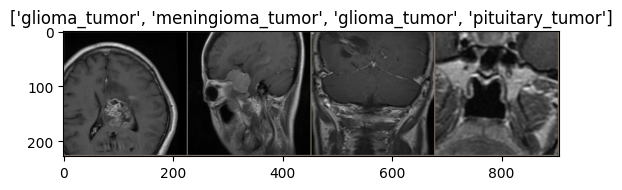

In [3]:
def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Getting a batch of training data
inputs, classes = next(iter(dataloaders['Training']))

# Making a grid from batch
out = torchvision.utils.make_grid(inputs)

#Let's show them with their titles of class names
imshow(out, title=[class_names[x] for x in classes])

In [4]:
criterion = nn.CrossEntropyLoss()  # Binary Cross Entropy with Logits
model = torch.hub.load('pytorch/vision:v0.16.0', 'efficientnet_v2_s', weights="IMAGENET1K_V1")
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

#vgg16 long dropout 0.7

Using cache found in C:\Users\emiel/.cache\torch\hub\pytorch_vision_v0.16.0


In [5]:
model.fc = nn.Linear(in_features=2048, out_features=4)

In [6]:
model = model.to(device)

In [7]:
summary(model, (3,224,224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 24, 112, 112]             648
       BatchNorm2d-2         [-1, 24, 112, 112]              48
              SiLU-3         [-1, 24, 112, 112]               0
            Conv2d-4         [-1, 24, 112, 112]           5,184
       BatchNorm2d-5         [-1, 24, 112, 112]              48
              SiLU-6         [-1, 24, 112, 112]               0
   StochasticDepth-7         [-1, 24, 112, 112]               0
       FusedMBConv-8         [-1, 24, 112, 112]               0
            Conv2d-9         [-1, 24, 112, 112]           5,184
      BatchNorm2d-10         [-1, 24, 112, 112]              48
             SiLU-11         [-1, 24, 112, 112]               0
  StochasticDepth-12         [-1, 24, 112, 112]               0
      FusedMBConv-13         [-1, 24, 112, 112]               0
           Conv2d-14           [-1, 96,

In [8]:
def validate():
    correct = 0
    total = 0
    # since we're not training, we don't need to calculate the gradients for our outputs
    with torch.no_grad():
        for data in dataloaders['Testing']:
            inputs, labels = data
            
            inputs = inputs.to(torch.device('cuda'))
            labels = labels.to(torch.device('cuda'))
            
            # calculate outputs by running images through the network
            outputs = model(inputs)
            # the class with the highest energy is what we choose as prediction
            loss = criterion(outputs, labels)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
    return loss.item(), 100 * correct / total

In [9]:
epochs = 50
for epoch in range(epochs):  # loop over the dataset multiple times

    running_loss = 0.0
    print()
    pbar = tf.keras.utils.Progbar(target=len(dataloaders['Training']))
    
    correct = 0
    total = 0
    
    for i, data in enumerate(dataloaders['Training'], 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        
        inputs = inputs.to(torch.device('cuda'))
        labels = labels.to(torch.device('cuda'))

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        pbar.update(i, values=[("loss",loss.item())])
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        
    test_loss, test_accuracy = validate()
    train_accuracy = 100 * correct / total
    pbar.update(i, values=[("train_accuracy", train_accuracy), ("test_accuracy", test_accuracy), ("test_loss",test_loss)])
    running_loss = 0.0

print('Finished Training')


717/718 [============================>.] - ETA: 0s - loss: 0.0860 - train_accuracy: 97.3171 - test_accuracy: 83.2487 - test_loss: 0.1345Finished Training


In [10]:
predictions = []
alllabels = []
with torch.no_grad():
        for data in dataloaders['Testing']:
            inputs, labels = data
            
            inputs = inputs.to(torch.device('cuda'))
            labels = labels.to(torch.device('cuda'))
            
            # calculate outputs by running images through the network
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            
            predictions.append(predicted.cpu().data.numpy())
            alllabels.append(labels.cpu().data.numpy())

In [11]:
def random_classification():
    with torch.no_grad():
        index = random.randint(0, batch_size - 1)
        dataiter = iter(dataloaders['Testing'])
        input, labels = next(dataiter)

        predictions = model(input)
        label = class_names[labels[index].item()]

        predicted_label = class_names[predictions[index].argmax().item()]

        # Normalize the input image to the range [0, 1]
        img = input[index].permute(1, 2, 0)
        img = (img - img.min()) / (img.max() - img.min())

        plt.imshow(img)
        plt.title(f"Real: {label} \nPrediction: {predicted_label}\n", color='green' if label == predicted_label else 'red')
        plt.show()

In [12]:
class_names

['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']

In [13]:
model = model.to("cpu")

In [79]:
targets, classes = next(iter(dataloaders['Testing']))

In [80]:
classes

tensor([1, 1, 0, 2])

In [103]:
target = targets[:1]

In [104]:
e = shap.GradientExplainer((model, model.features[-1]), next(iter(dataloaders['Testing']))[0], local_smoothing = 0.1)
shap_values, indexes = e.shap_values(target, ranked_outputs=1, nsamples=150
)

IndexError: index 1 is out of bounds for axis 0 with size 1

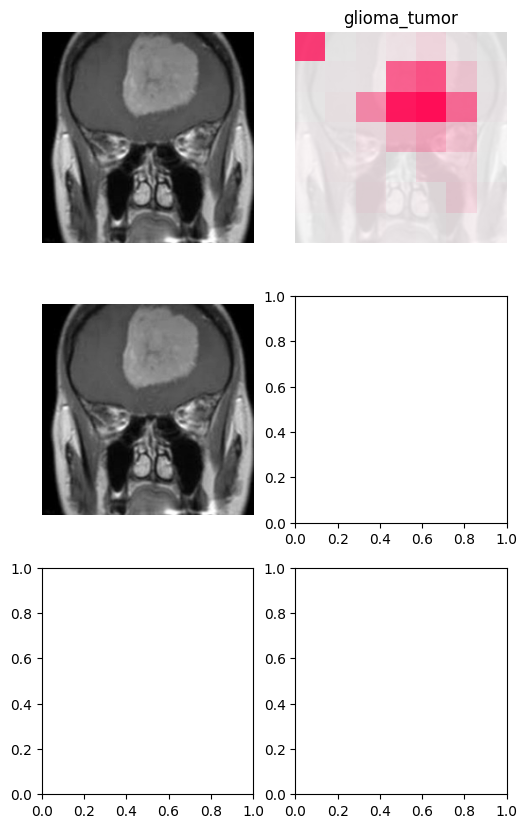

In [105]:
# get the names for the classes
index_names = class_names

# plot the explanations
shap_values = [np.swapaxes(np.swapaxes(s, 2, 3), 1, -1) for s in shap_values]
shap.image_plot(shap_values, np.array(target)[0], index_names)

In [ ]:
random_classification()